CIFAR-10 dataset labels -> airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Image classification using TensorFlow 1.14.0

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    
    return features, labels

In [5]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cifar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}. {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    
    print('\nStats of batch #{}:'.format(batch_id))
    print('# of samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of image {}:'.format(sample_id))
    print('Image - Min value: {} Max value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of samples: 10000

Label counts of [0](AIRPLANE) : 994
Label counts of [1](AUTOMOBILE) : 1042
Label counts of [2](BIRD) : 965
Label counts of [3](CAT) : 997
Label counts of [4](DEER) : 990
Label counts of [5](DOG) : 1029
Label counts of [6](FROG) : 978
Label counts of [7](HORSE) : 1015
Label counts of [8](SHIP) : 961
Label counts of [9](TRUCK) : 1029

Example of image 7000:
Image - Min value: 24 Max value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


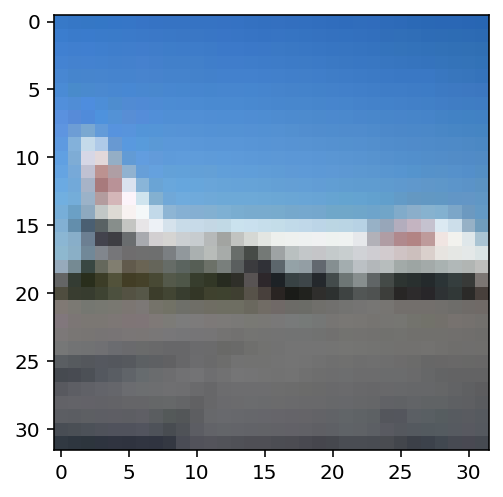

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [6]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [7]:
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [8]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))
    
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cifar10_batch(cifar10_dataset_folder_path, batch_i)
        
        index_of_validation = int(len(features) * 0.1)
        
        _preprocess_and_save(normalize, one_hot_encode,
                            features[:-index_of_validation], labels[:-index_of_validation],
                            'preprocess_batch_' + str(batch_i) + '.p')
        
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
        
    _preprocess_and_save(normalize, one_hot_encode,
                        np.array(valid_features), np.array(valid_labels),
                        'preprocess_validation.p')
    
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    
    _preprocess_and_save(normalize, one_hot_encode,
                        np.array(test_features), np.array(test_labels),
                        'preprocess_training.p')

In [9]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [10]:
import pickle
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [19]:
import tensorflow as tf
tf.reset_default_graph()

# placeholder and reset_default_graph functions deprecated in version 2, for using them we use tf.compat.v1.
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='rate')

In [20]:
def conv_net(x, keep_prob):
    '''
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))
    '''
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))
    
    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    
    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
    
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.layers.flatten(conv4_bn)
    
    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out;

In [21]:
epochs = 5
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [22]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [23]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,
               feed_dict={
                   x: feature_batch,
                   y: label_batch,
                   keep_prob: keep_probability
               })

In [24]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                   feed_dict={
                       x: feature_batch,
                       y: label_batch,
                       keep_prob: 1.
                   })
    valid_acc = sess.run(accuracy, 
                        feed_dict={
                            x: valid_features,
                            y: valid_labels,
                            keep_prob: 1.
                        })
    print('Loss: {:>10.4f} Validation accuracy: {:.6f}'.format(loss, valid_acc))

In [25]:
def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def load_preprocess_training_batch(batch_id, batch_size):
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    return batch_features_labels(features, labels, batch_size)

In [26]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initializing the variables
    
    # training cycle
    for epoch in range(epochs):
        # loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}: '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # save model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1: Loss:     2.1839 Validation accuracy: 0.193400
Epoch  1, CIFAR-10 Batch 2: Loss:     1.8532 Validation accuracy: 0.257800
Epoch  1, CIFAR-10 Batch 3: Loss:     1.5789 Validation accuracy: 0.265800
Epoch  1, CIFAR-10 Batch 4: Loss:     1.6866 Validation accuracy: 0.327400
Epoch  1, CIFAR-10 Batch 5: Loss:     1.4777 Validation accuracy: 0.372600
Epoch  2, CIFAR-10 Batch 1: Loss:     1.4422 Validation accuracy: 0.453200
Epoch  2, CIFAR-10 Batch 2: Loss:     1.2248 Validation accuracy: 0.425600
Epoch  2, CIFAR-10 Batch 3: Loss:     1.1263 Validation accuracy: 0.526400
Epoch  2, CIFAR-10 Batch 4: Loss:     1.1598 Validation accuracy: 0.568200
Epoch  2, CIFAR-10 Batch 5: Loss:     0.8668 Validation accuracy: 0.598200
Epoch  3, CIFAR-10 Batch 1: Loss:     0.8177 Validation accuracy: 0.612400
Epoch  3, CIFAR-10 Batch 2: Loss:     0.7523 Validation accuracy: 0.628400
Epoch  3, CIFAR-10 Batch 3: Loss:     0.6286 Validation accuracy: 0.638600
Epoch  3, CIF

The model has been saved to the disk.

In [27]:
# Testing model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    # split features and labels into batches
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))
    
    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax predictions', fontsize=20, y=1.1)
    
    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, 
                                                                                  label_ids, 
                                                                                  predictions.indices,
                                                                                  predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature * 255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()
            
            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing accuracy: 0.7060111464968153



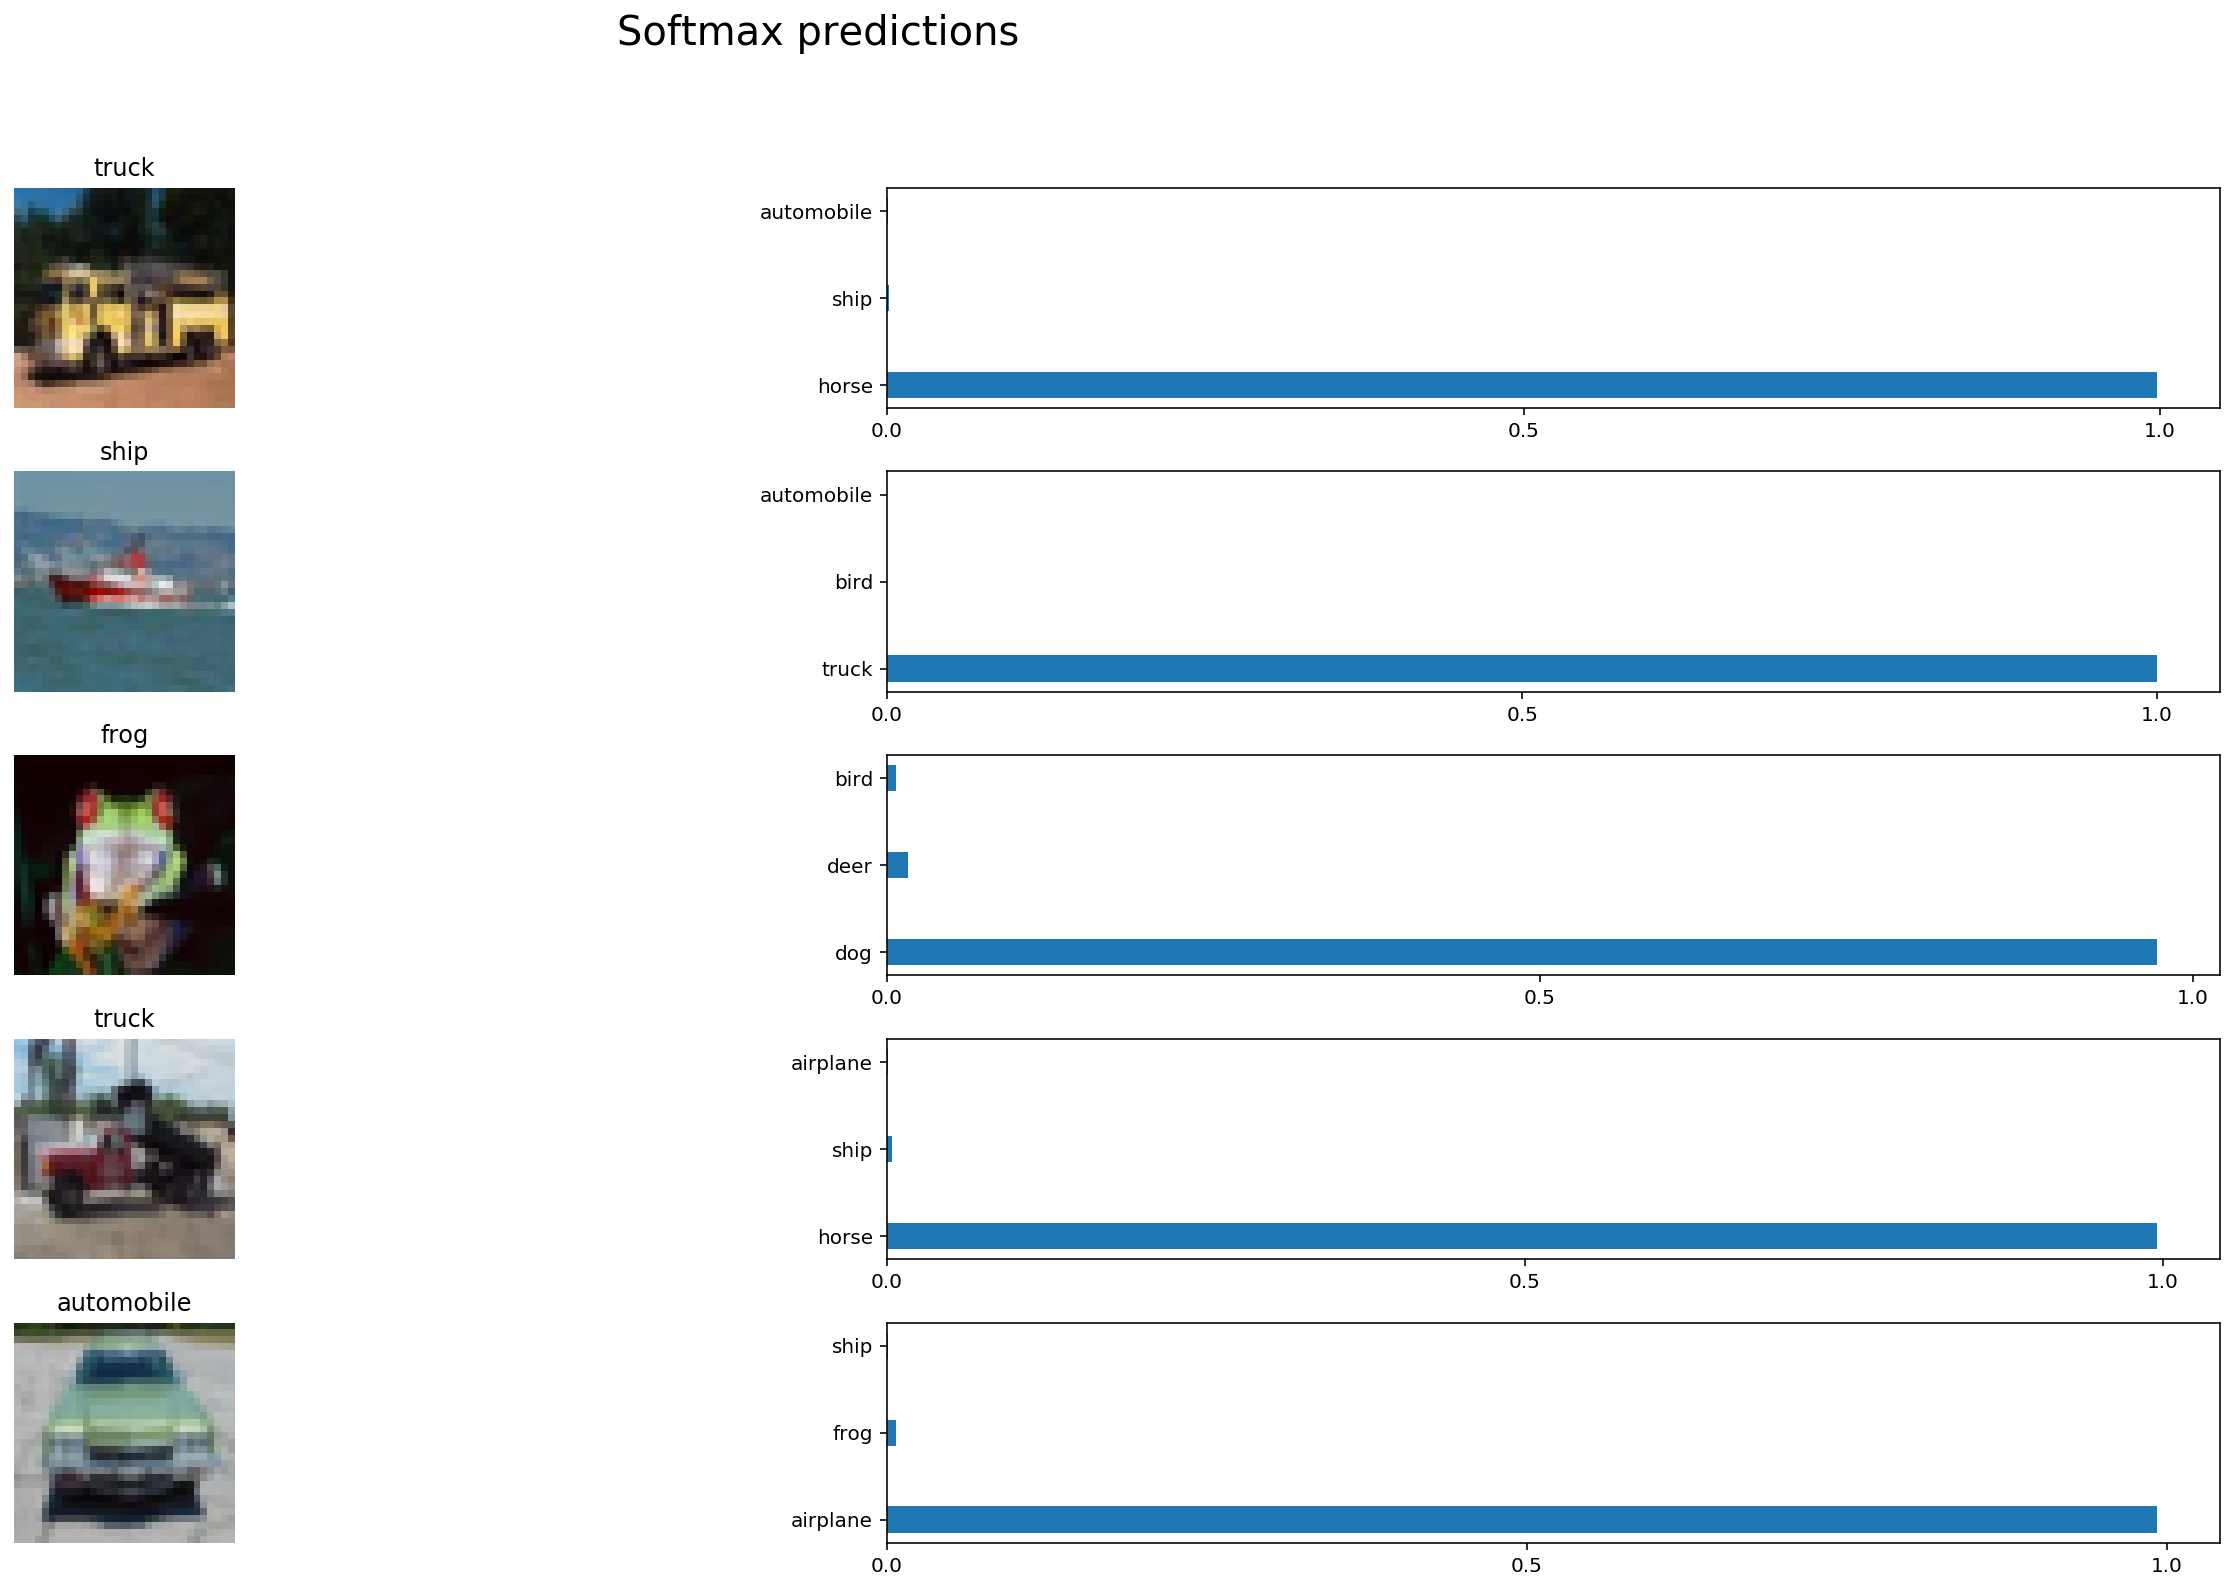

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        # load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # get tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('rate:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1
            
        print('Testing accuracy: {}\n'.format(test_batch_acc_total / test_batch_count))
        
        # print random samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)
        
test_model()

References;
- https://www.youtube.com/watch?v=AACPaoDsd50
- https://www.tensorflow.org/guide/migrate